# __Group 5 DSCI 100 Project__

## Introduction

### Background information:
- Research conducted by UBC research group, Pacific Laboratory for Artificial Intelligence
- Data was collected through minecraft server
- Goal of creating an AI able to understand speech, and respond in a complex virtual environment

### Research Question
- "Can the status of subscribing to a game-related newsletter be predicted from age and hours played?"

### players.csv:
- The players dataframe has 196 observations, with 7 variables
- This gives information on the demographics of players who log onto PLAI's minecraft server

| Variable | Description | Data type |
|----------|-------------|-----------|
| experience | Self-identifying Level of Experience | chr|
| subscribe  | Game Newsletter Subscription Status | lgl |
| hashedEmail | Hashed Version of Player Email | chr |
| played_hours | Hours spent in game | dbl |
| name | Name of player | chr |
| gender | Gender of player | chr |
| age | Age of player | dbl |

**Summary of Quantitative Variables**

| Variable | Min | Max | Mean |
|----------|-----|-----|------|
| played_hours | 0.00 | 223.10 | 5.85|
|age | 9.00 | 58.00 | 21.14 |

There is a large spread of values for played values, with a maximum of 223, but a mean of 5.85; this can be presented as an outlier value.

## Methods

In [4]:
# loading in libraries and datasets
library(tidyverse)
players_info <- read_csv('data/players.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
# tidying and wrangling data
tidy_players_info <- players_info |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(experience = as.factor(experience)) |>
    filter(na.rm = TRUE) |>
    select(subscribe, played_hours, Age)
head(tidy_players_info) 

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


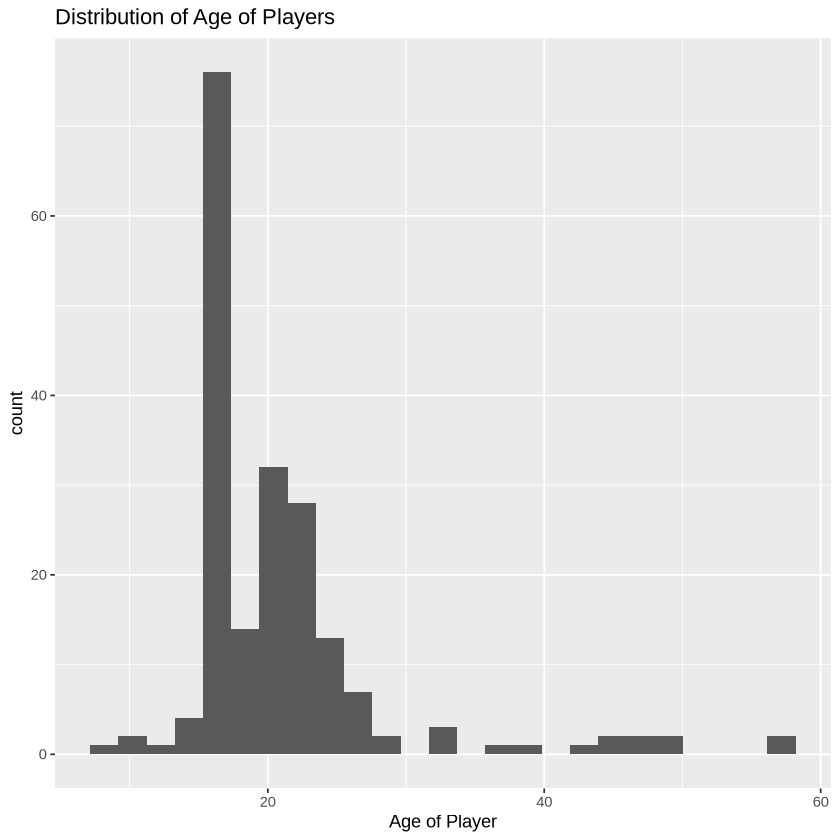

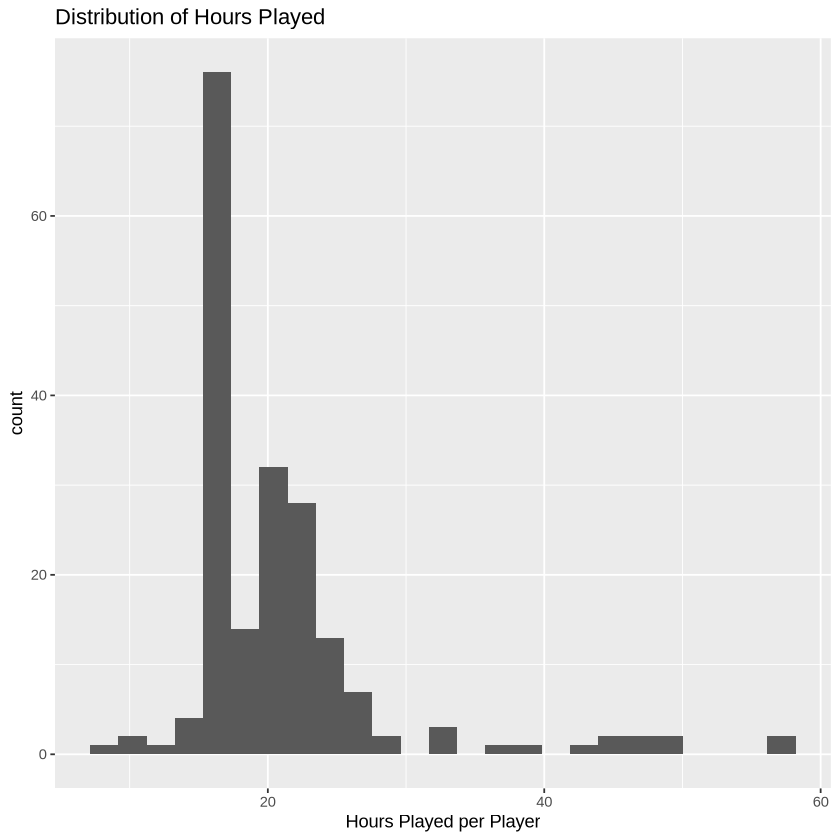

In [9]:
# distribution of data
age_distribution <- tidy_players_info |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 25) +
    labs(x = 'Age of Player', title = 'Distribution of Age of Players')

played_hours_distribution <- tidy_players_info |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 25) +
    labs(x = 'Hours Played per Player', title = 'Distribution of Hours Played')

age_distribution
played_hours_distribution

## Results

Where the results go

## Discussion

- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to